In [5]:
%matplotlib inline

import os, sys

import IPython.display as ipd
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
import ast
from tqdm import tqdm

from collections import OrderedDict

plt.rcParams['figure.figsize'] = (17, 5)

# Gain metainfo

In [2]:
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

In [3]:
AUDIO_DIR = "/home/jupyter/datasphere/project/DeepGenerativeModels/project/fma"

# Load metadata and features.
tracks = load(f'{AUDIO_DIR}/fma_metadata/tracks.csv')
genres = load(f'{AUDIO_DIR}/fma_metadata/genres.csv')

tracks.shape, genres.shape, 

((106574, 52), (163, 4))

In [4]:
small = tracks[tracks['set', 'subset'] <= 'small']

In [6]:
def get_audio_path(path, number):
    return "/home/jupyter/datasphere/project/DeepGenerativeModels/project/fma/000140.mp3"
filename = get_audio_path(AUDIO_DIR, 10250)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, duration=76, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
# ipd.Audio(data=x[start*sr:end*sr], rate=sr)
ipd.Audio(data=x, rate=sr)

File: /home/jupyter/datasphere/project/DeepGenerativeModels/project/fma/000140.mp3
Duration: 29.98s, 1321967 samples


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
from tqdm.notebook import tqdm

In [93]:
PIECE_LEN = 2**15*8


class Dataset(torch_data.Dataset):
    def __init__(self, data: pd.DataFrame):
        self.mel = []
        self.genres = []
        self.n = 512

        self.genre_to_index = {k:i for i, (k, v) in enumerate(small.track['genre_top'].value_counts().to_dict().items()) if v > 0}
        self.index_to_genre = {v:k for k, v in self.genre_to_index.items()}


        for i in tqdm(data.track[['duration', 'genre_top']].index):
            row = data.track.loc[i, ['duration', 'genre_top']]
            filename = get_audio_path(AUDIO_DIR, i)   
            try:
                x, sr = librosa.load(filename, sr=None, duration=row.duration, mono=True)
                x = librosa.feature.melspectrogram(y=x, sr=44100, n_fft=2048)
                print(x.shape)
                if sr != 44100 or len(x[0]) < self.n:
                    continue
                self.mel.append(x)
                self.genres.append(self.genre_to_index[row.genre_top])
            except Exception as e:
                print(f"File {i} is broken")

    def __getitem__(self, index):
        start = np.random.choice(self.mel[index].shape[1] - self.n, size=1)[0] 
        mel = self.mel[index][:, start: start + self.n]
        
        #print(f"{mel.shape = }")
        # rt = librosa.feature.melspectrogram(y=audio, sr=44100, n_fft=2048)
        return torch.Tensor(mel.transpose((1, 0)))

    def __len__(self) -> int:
        return len(self.wav)


class DataLoader:
    def __init__(self, dataset, batch_size=32):
        self.dataset = dataset
        self.batch_size = 32
    
    def __iter__(self):
        return self
    
    def __next__(self):
        return torch.stack([self.dataset[0][None, :, :] for _ in range(self.batch_size)], dim=0)

In [94]:
dataset = Dataset(small[small.index == 140])
dataloader = iter(DataLoader(dataset, batch_size=32))
next(dataloader).shape

  0%|          | 0/1 [00:00<?, ?it/s]

(128, 2582)


torch.Size([32, 1, 512, 128])

In [95]:
show_spectogram(next(dataloader))

(128, 512)
(261632,)


In [96]:
import torch.nn.functional as F


class Block(nn.Module):
    def __init__(self, length, n_channels, do_halfing=False, do_doubling=False):
        super().__init__()
        multiplier = 2 if do_halfing else 1
        #self.lstm = nn.Conv1d(n_channels, multiplier * n_channels, kernel_size=7, padding=3) 
        self.lstm = nn.LSTM(n_channels, n_channels, bidirectional=do_halfing, batch_first=True)
        self.do_doubling = do_doubling
        self.bn = nn.BatchNorm1d(length)
        self.conv = nn.Conv1d(multiplier * n_channels, (2 if do_doubling else 1) * n_channels, kernel_size=7, padding=3, stride=multiplier)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        #x = self.lstm(x.transpose(1, 2)).transpose(1, 2)
        x = F.relu(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.conv(x.transpose(1, 2)).transpose(1, 2)
        x = F.relu(x)
        if self.do_doubling:
            x = x.reshape((x.shape[0], x.shape[1], 2, x.shape[2] // 2))
            x = x.reshape((x.shape[0], 2 * x.shape[1], x.shape[-1]))
        return x

    
class Encoder(nn.Module):
    def __init__(self, length, channels, num_times, blocks_num=3):
        super().__init__()
        assert length % (2 ** num_times) == 0
        layers = []
        for i in range(num_times):
            for _ in range(blocks_num):
                layers.append(Block(length, channels))
            layers.append(Block(length, channels, do_halfing=True))
            length //= 2
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

    
class Decoder(nn.Module):
    def __init__(self, length, channels, num_times, blocks_num=3):
        super().__init__()
        assert length % (2 ** num_times) == 0
        length //= 2 ** num_times
        layers = []
        for i in range(num_times):
            for _ in range(blocks_num):
                layers.append(Block(length, channels))
            layers.append(Block(length, channels, do_doubling=True))
            length *= 2
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x).exp()

    
class Block2(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, n_channels, kernel_size=7, padding="same")
        self.conv2 = nn.Conv2d(n_channels, n_channels, kernel_size=7, padding="same")
        
        self.bn = nn.BatchNorm2d(n_channels)

    def forward(self, x):
        x_copy = x
        x = F.relu(self.conv1(x))
        x = self.bn(x)
        x = F.relu(self.conv2(x))
        return x + x_copy

        
class DownBlock(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.model = nn.Sequential(Block2(n_channels), nn.Conv2d(n_channels, 2 * n_channels, kernel_size=7, padding=3, stride=2))
    
    def forward(self, x):
        return self.model(x)


class UpBlock(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.model = nn.Sequential(
            Block2(n_channels),
            nn.ConvTranspose2d(n_channels, n_channels // 2, kernel_size=8, padding=3, stride=2),
            nn.ReLU()
        )
    
    def forward(self, x):
        rt = self.model(x)
        return rt

    
class Encoder2(nn.Module):
    def __init__(self, num_blocks=7, num_per_block=3):
        super().__init__()
        layers = []
        channels = 1
        for i in range(num_blocks):
            for j in range(num_per_block):
                layers.append(Block2(channels))
            layers.append(DownBlock(channels))
            channels *= 2
        
        #for layer in (layers):
        #    print(layer)
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

    
    
class Decoder2(nn.Module):
    def __init__(self, num_blocks=7, num_per_block=3):
        super().__init__()
        layers = []
        channels = 2 ** num_blocks
        for i in range(num_blocks):
            layers.append(UpBlock(channels))
            channels //= 2
            for j in range(num_per_block):
                layers.append(Block2(channels))
        
        #for layer in (layers):
        #    print(layer)
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)
#b = Block(512, 128, do_halfing=True, do_doubling=False)
#e = Encoder(512, 128, 7)
#d = Decoder(512, 128, 7)
#
#
#input_tensor = next(dataloader)
#latent_representation = e(input_tensor)
#reconstruction = d(latent_representation)
#input_tensor.shape, latent_representation.shape, reconstruction.shape, 
b = Block2(1)
input_tensor = next(dataloader) #torch.rand((32, 1, 512, 128))
latent_representation = Encoder2()(input_tensor)
print(b(input_tensor).shape, latent_representation.shape, Decoder2()(latent_representation).shape)

torch.Size([32, 1, 512, 128]) torch.Size([32, 128, 4, 1]) torch.Size([32, 1, 512, 128])


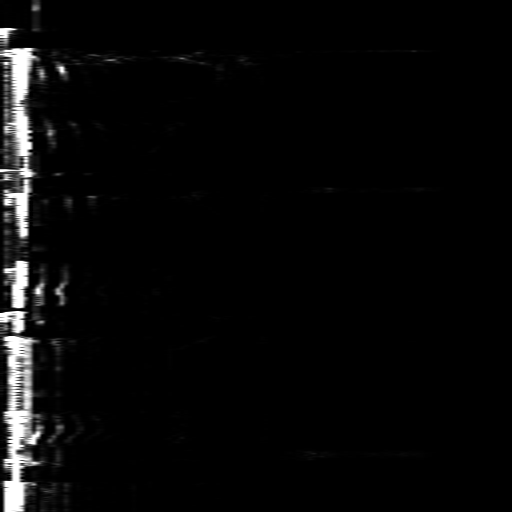

(261632,)


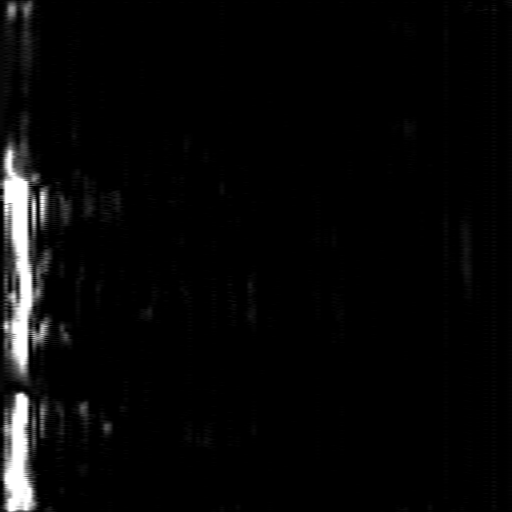

(261632,)


In [98]:
from PIL import Image


def show_spectogram(x, n=10):
    x_image = x[0][0].clip(0, n) * 255 / n
    #print(x_image.shape)
    x_image = np.array(x_image).astype(np.uint8)
    display(Image.fromarray(x_image).resize((512, 512)))
    
    x = np.array(x[0][0]).transpose(1, 0)
    #print(x.shape)
    rt = librosa.feature.inverse.mel_to_audio(x, sr=44100, n_fft=2048)
    print(rt.shape)
    display(ipd.Audio(data=rt, rate=44100))
    #return rt
show_spectogram(input_tensor)
show_spectogram(reconstruction.detach().cpu().numpy())

In [103]:
length = 512
channels = 128
num_layer = 7

device = "cuda" if torch.cuda.is_available() else "cpu"

#encoder = Encoder(length, channels, num_layer).to(device)
#decoder = Decoder(length, channels, num_layer).to(device)
encoder = Encoder2().to(device)
decoder = Decoder2().to(device)

optim = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
loss_function = torch.nn.L1Loss()

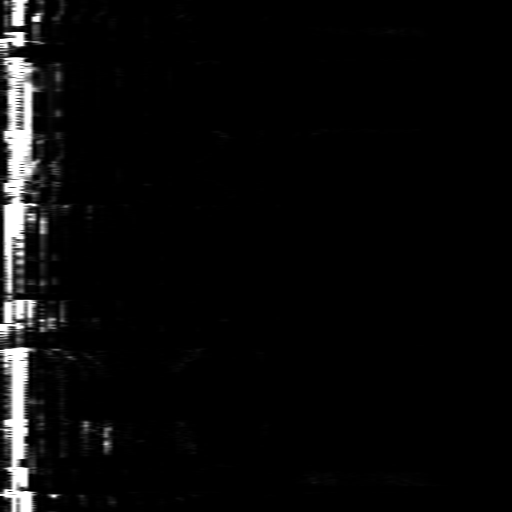

(261632,)


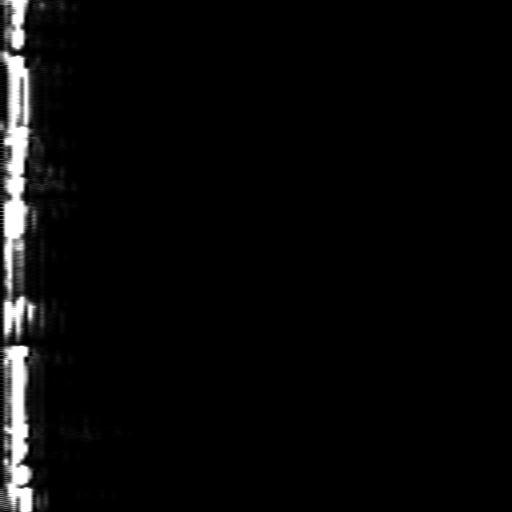

(261632,)


Loss = 0.56
Loss = 0.52
Loss = 0.54
Loss = 0.53
Loss = 0.55
Loss = 0.57
Loss = 0.54
Loss = 0.52
Loss = 0.57
Loss = 0.50
Loss = 0.51
Loss = 0.53
Loss = 0.55
Loss = 0.55
Loss = 0.56
Loss = 0.55
Loss = 0.55
Loss = 0.53
Loss = 0.55
Loss = 0.53
Loss = 0.50
Loss = 0.54
Loss = 0.54
Loss = 0.54
Loss = 0.53
Loss = 0.53
Loss = 0.50
Loss = 0.52
Loss = 0.54
Loss = 0.55
Loss = 0.51
Loss = 0.51
Loss = 0.49
Loss = 0.49
Loss = 0.53
Loss = 0.54
Loss = 0.55
Loss = 0.58
Loss = 0.53
Loss = 0.55
Loss = 0.57
Loss = 0.53
Loss = 0.53
Loss = 0.56
Loss = 0.52
Loss = 0.53
Loss = 0.55
Loss = 0.56
Loss = 0.53
Loss = 0.54
Loss = 0.52
Loss = 0.56
Loss = 0.52
Loss = 0.60
Loss = 0.54
Loss = 0.52
Loss = 0.54
Loss = 0.57
Loss = 0.55
Loss = 0.59
Loss = 0.51
Loss = 0.51
Loss = 0.58
Loss = 0.57
Loss = 0.53
Loss = 0.59
Loss = 0.51
Loss = 0.58
Loss = 0.61
Loss = 0.56
Loss = 0.53
Loss = 0.51
Loss = 0.53
Loss = 0.54
Loss = 0.55
Loss = 0.56
Loss = 0.53
Loss = 0.55
Loss = 0.56
Loss = 0.54
Loss = 0.57
Loss = 0.55
Loss = 0.55
Loss

KeyboardInterrupt: 

In [104]:
from IPython.display import clear_output

i = 0
while True:
    x = next(dataloader).to(device)
    reconstruction = decoder(encoder(x))
    loss = loss_function(x, reconstruction)
    optim.zero_grad()
    loss.backward()
    optim.step()

    print(f"Loss = {loss.item():.2f}")
    i += 1
    if i % 500 == 499:
        clear_output()
        show_spectogram(x.cpu())
        show_spectogram(reconstruction.detach().cpu())

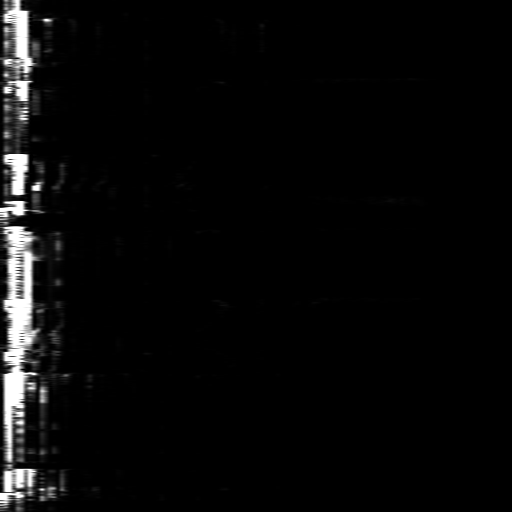

/usr/local/lib/python3.10/dist-packages/librosa/feature/inverse.py:102: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


(65024,)


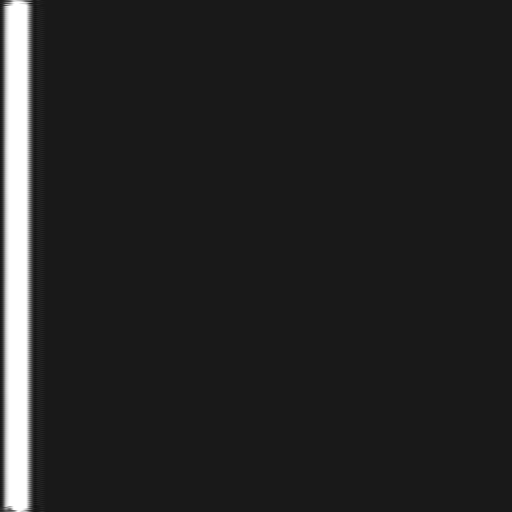

/usr/local/lib/python3.10/dist-packages/librosa/feature/inverse.py:102: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


(65024,)


In [71]:
show_spectogram(x)
show_spectogram(reconstruction.detach())

In [41]:
class ConvNextBlock(nn.Module):
    def __init__(self, input_channels, hidden_size, kernel_size):
        super(ConvNextBlock, self).__init__()

        self.net = nn.Sequential(
            OrderedDict([
                ('conv_1', nn.Conv1d(input_channels, input_channels, kernel_size=kernel_size, padding=kernel_size//2)),
                ('ln', nn.InstanceNorm1d(input_channels)),
                ('conv_2', nn.Conv1d(input_channels, hidden_size, kernel_size=1, padding=0)),
                ('gelu', nn.GELU()),
                ('conv_3', nn.Conv1d(hidden_size, input_channels, kernel_size=1, padding=0)),
            ])
        )
    def forward(self, x):
        return x + self.net(x)


class MyBlock(nn.Module):
    def __init__(self, input_channels, output_channels, downsampling=True):
        super(MyBlock, self).__init__()

        layers = []
        if not downsampling:
            layers.append(
                nn.ConvTranspose1d(
                    in_channels=input_channels,
                    out_channels=output_channels,
                    kernel_size=3, stride=2, dilation=2, output_padding=1, padding=2
                )
            )
        else:
            layers.append(
                nn.Conv1d(
                    in_channels=input_channels,
                    out_channels=output_channels,
                    kernel_size=3, stride=2, padding=1
                )
            )
        layers.append(nn.InstanceNorm1d(output_channels))
        layers.append(nn.GELU())
        
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

In [42]:
class Encoder(nn.Module):
    def __init__(self, encoder_hidden, final_size):
        super(Encoder, self).__init__()
        # Encoder: (1, L = 2**15 * 6) -> (256, L = 2**8 * 3)  -- 8 сжатий
        self.encoder = nn.Sequential(
            MyBlock(input_channels=1, output_channels=8, downsampling=True),
            MyBlock(input_channels=8, output_channels=32, downsampling=True),
            MyBlock(input_channels=32, output_channels=encoder_hidden, downsampling=True),

            ConvNextBlock(input_channels=encoder_hidden, hidden_size=384, kernel_size=7),
            nn.MaxPool1d(kernel_size=2),

            ConvNextBlock(input_channels=encoder_hidden, hidden_size=384, kernel_size=7),
            nn.MaxPool1d(kernel_size=2),

            ConvNextBlock(input_channels=encoder_hidden, hidden_size=384, kernel_size=7),
            nn.MaxPool1d(kernel_size=2),

            ConvNextBlock(input_channels=encoder_hidden, hidden_size=384, kernel_size=7),
            nn.MaxPool1d(kernel_size=2),

            ConvNextBlock(input_channels=encoder_hidden, hidden_size=384, kernel_size=7),
            nn.MaxPool1d(kernel_size=2),
            
        )
        self.mean = nn.Conv1d(
                    in_channels=encoder_hidden,
                    out_channels=final_size,
                    kernel_size=3, padding=1
                )
        self.logvar = nn.Conv1d(
                    in_channels=encoder_hidden,
                    out_channels=final_size,
                    kernel_size=3, padding=1
                )
    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, inputs):        
        # Encoded feature map
        hidden = self.encoder(inputs)
        # Calculate mean and (log)variance
        mean, logvar = self.mean(hidden), self.logvar(hidden)
        # Sample
        latent_z = self.reparametrize(mean, logvar)
        return latent_z, mean, logvar


class Decoder(nn.Module):
    def __init__(self, encoder_hidden, final_size):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Conv1d(
                    in_channels=final_size,
                    out_channels=encoder_hidden,
                    kernel_size=3, padding=1
            ),
            nn.Upsample(scale_factor=2),
            ConvNextBlock(input_channels=encoder_hidden, hidden_size=384, kernel_size=7),
            
            nn.Upsample(scale_factor=2),
            ConvNextBlock(input_channels=encoder_hidden, hidden_size=384, kernel_size=7),
            
            nn.Upsample(scale_factor=2),
            ConvNextBlock(input_channels=encoder_hidden, hidden_size=384, kernel_size=7),

            nn.Upsample(scale_factor=2),
            ConvNextBlock(input_channels=encoder_hidden, hidden_size=384, kernel_size=7),

            nn.Upsample(scale_factor=2),
            ConvNextBlock(input_channels=encoder_hidden, hidden_size=384, kernel_size=7),

            MyBlock(input_channels=encoder_hidden, output_channels=32, downsampling=False),
            MyBlock(input_channels=32, output_channels=8, downsampling=False),
            MyBlock(input_channels=8, output_channels=1, downsampling=False),
            nn.Conv1d(
                    in_channels=1,
                    out_channels=1,
                    kernel_size=3, padding=1
            ),
        )

    def forward(self, input):
        return self.decoder(input)

class VAE(nn.Module):
    def __init__(self, encoder, decoder, final_size, genres_size=8, is_train=True, ):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = encoder
        # Decoder
        self.decoder = decoder
        self.genre_embed = nn.Embedding(num_embeddings=genres_size, embedding_dim=final_size)
        self.final_size = final_size

        if is_train == False:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False

    def forward(self, x, genres):
        latent_z, mean, logvar = self.encoder(x)
        genre_embed = self.genre_embed(genres)
        rec_x = self.decoder(latent_z + genre_embed.unsqueeze(dim=-1))
        return rec_x, mean, logvar
    
    def encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z
        
    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def sample(self, batch_size, genres=None, length=2**8 * 3):
        if not genres:
            genres = torch.randint(low=0, high=8, size=[batch_size], dtype=torch.long, device=device)
        genre_embed = self.genre_embed(genres)
        sample = torch.randn(size=[batch_size, self.final_size, length]).to(device) + genre_embed.unsqueeze(dim=-1)
        return self.decoder(sample)


In [103]:
encoder_hidden = 96
final_size = 128

encoder = Encoder(encoder_hidden, final_size)
decoder = Decoder(encoder_hidden, final_size)
model = VAE(encoder, decoder, final_size)
print(f"Model has {sum([p.numel() for p in model.parameters()])} parameters")


Model has 1520325 parameters


In [72]:
embeddings_model = torch.load("fma/vae_model.pt", map_location="cpu")
embeddings_model.eval()
None
#model.load_state_dict(t.state_dict())

In [ ]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, torch.Tensor(t).to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)


def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

In [ ]:
# DDPM class
class DDPM(nn.Module):
    def __init__(self, network, # Unet
                 n_steps=1000, # YOUR CODE HERE (число шагов диффузии)
                 min_beta=1e-5, # YOUR CODE HERE
                 max_beta=1e-2, # YOUR CODE HERE
                 device=None,
                 image_chw=(3, image_size, image_size)):
        super().__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device) # Ваш backbone (Unet), реализуете его ниже
        self.betas = make_beta_schedule(n_timesteps=n_steps, start=min_beta, end=max_beta).to(device) # Задайте beta по любой понравившейся сетке, как на семинаре
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def forward(self, x0, t, eta=None):
        # Прямой проход диффузии (детерменированный марковский процесс)
        # :param x0 - исходная картинка (тензор формы [B,C,H,W])
        # :param t - шаг зашумления (тензор формы [B,1])
        # :param eta - \epsilon_t - добавочный шум на шаге зашумления t (тензор формы [B,C,H,W])
        
        # YOUR CODE HERE
        if eta is None:
            eta = torch.randn_like(x0, device=device) # если шум не определен - инициализируйте его гауссом N(0,1) сами
        
        alpha_t_bars = extract(self.alpha_bars, t, x0)
        noised_x = torch.sqrt(alpha_t_bars) * x0 + torch.sqrt(1 - alpha_t_bars) * eta
        return noised_x

    def backward(self, x, t):
        # Обратный процесс. Здесь вам предстоит восстановить добавочный шум eta из зашумлённой картинки x на шаге t нейросетью
        eta_pred = self.network(x, t)
        
        return eta_pred

In [115]:
batch = next(iter(dataloader))
batch = (batch[0].unsqueeze(dim=1), batch[1])
print([elem.shape for elem in batch])
t = embeddings_model.encode(batch2[0]).permute((0, 2, 1))
t.shape

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[torch.Size([1, 1, 196608]), torch.Size([1])]


torch.Size([2, 768, 128])

In [131]:
import torch
import torch.nn as nn

class MultiAttentionConcat(nn.Module):
    def __init__(self, embeddings_dim, num_heads=8):
        super(MultiAttentionConcat, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embeddings_dim // num_heads
        self.fc_query = nn.Linear(embeddings_dim, embeddings_dim)
        self.fc_key = nn.Linear(embeddings_dim, embeddings_dim)
        self.fc_value = nn.Linear(embeddings_dim, embeddings_dim)
        self.fc_concat = nn.Linear(embeddings_dim, embeddings_dim)

    def forward(self, x):
        batch_size, length, _ = x.size()
        
        query = self.fc_query(x)
        key = self.fc_key(x)
        value = self.fc_value(x)
        
        query = query.view(batch_size, length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        key = key.view(batch_size, length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        value = value.view(batch_size, length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        attention_scores = torch.matmul(query, key.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attention_weights = nn.functional.softmax(attention_scores, dim=-1)
        
        attended_values = torch.matmul(attention_weights, value)
        attended_values = attended_values.permute(0, 2, 1, 3).contiguous().view(batch_size, length, -1)
        
        concatenated = self.fc_concat(attended_values)
        
        return concatenated
    

    
class ResBlock(nn.Module):
    def __init__(self, channels=128, kernel_size=7):
        super().__init__()
        self.convs = nn.Sequential(*sum([[nn.Conv1d(channels, channels, kernel_size, padding="same"), nn.ReLU()] for _ in range(5)], []))
        self.conv_final = nn.Conv1d(channels, channels, kernel_size, padding="same")
    
    def forward(self, x):
        x = x.permute((0, 2, 1))
        x_copy = x
        x = self.convs(x)
        x = x + x_copy
        rt = self.conv_final(x)
        rt = rt.permute((0, 2, 1))
        return rt
        
    

# Usage example
# batch_size = 32
length = 768
embeddings_dim = 128


model = nn.Sequential(*[])

input_tensor = torch.randn(batch_size, length, embeddings_dim)
multi_attention_concat = MultiAttentionConcat(embeddings_dim)
output = multi_attention_concat(input_tensor)
print(output.size())  # Output shape will be (batch_size, length, embeddings_dim)

torch.Size([32, 768, 128])


torch.Size([32, 768, 128])

In [119]:
import inspect
print(inspect.getsource(nn.Sequential.__init__))

    def __init__(self, *args):
        super().__init__()
        if len(args) == 1 and isinstance(args[0], OrderedDict):
            for key, module in args[0].items():
                self.add_module(key, module)
        else:
            for idx, module in enumerate(args):
                self.add_module(str(idx), module)



In [114]:
t.shape

torch.Size([2, 768, 128])

In [108]:
batch2 = [torch.cat([elem, elem], dim=0) for elem in batch]
print([elem.shape for elem in batch2])

[torch.Size([2, 1, 196608]), torch.Size([2])]


In [45]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.get_device_properties(device))
torch.cuda.mem_get_info(device)

RuntimeError: No CUDA GPUs are available

In [41]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [24]:
torch.randint(low=0, high=8, size=[1], dtype=torch.long, device=device)

tensor([1], device='cuda:0')

# train VAE

In [33]:
import torch.nn.functional as F

def loss_function(recon_x, x, mu, logvar):
    batch_size = recon_x.shape[0]
    ffts = [1024, 2048, 512]
    window_sizes = [600, 1200, 240]
    frame_shifts = [120, 240, 50]
    rec_loss = torch.zeros(1, device=device)
    
    for i in range(3):
        window = torch.hann_window(window_sizes[i], device=device)
        y_pred = torch.abs(torch.stft(recon_x[:, 0, :], ffts[i], hop_length=frame_shifts[i], win_length=window_sizes[i], window=window, return_complex=True))
        y_true = torch.abs(torch.stft(x[:, 0, :], ffts[i], hop_length=frame_shifts[i], win_length=window_sizes[i], window=window, return_complex=True))
        rec_loss += F.mse_loss(y_pred, y_true, reduction='sum') #/ torch.square(torch.sum(y_true**2))
    
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return rec_loss, KLD

log_interval=10
epochs=10


def train(pbar, model, optimizer):
    model.train()
    train_mse, train_kld, train_loss = 0, 0, 0
    
    for batch_idx, (data, genre) in enumerate(dataloader):
        data = data.to(device).unsqueeze(dim=1)
        genre = genre.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, genre)
        mse_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
        loss = mse_loss + kld_loss
        loss.backward()
        train_loss += loss.item()
        train_mse += mse_loss.item()
        train_kld += kld_loss.item()
        optimizer.step()
        pbar.set_description(f"[KL: {kld_loss.item()/len(data) :.2f}] [MSE: {mse_loss.item()/len(data): .2f}]")
        pbar.update(1)
    return train_loss

In [90]:
next(iter(dataloader))[0].shape

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([1, 196608])

In [58]:
dataloader = torch_data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=8,
    collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [35]:
sample = model.sample(1).numpy(force=True)

In [36]:
ipd.Audio(data=sample[0, 0], rate=44100)

/home/koltochenkoja/GEN/generative_project/project/lib/python3.10/site-packages/IPython/lib/display.py:188: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


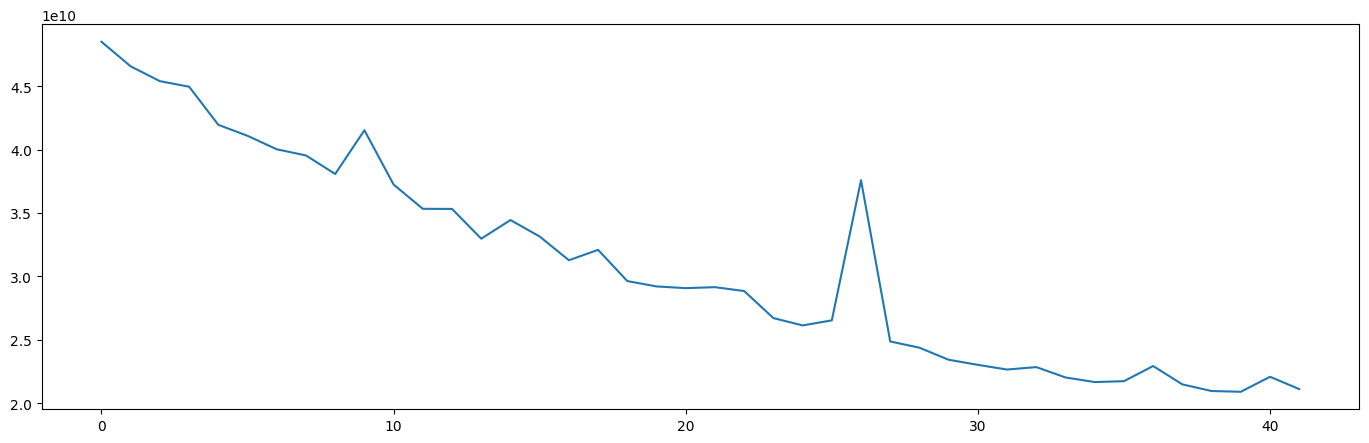

[KL: 154976.88] [MSE:  3360855.50]:  42%|▍| 40187/94700 [2:21:33<3:07:17,  4.85i

In [ ]:
epochs = 100
losses = []
with tqdm(total=epochs*len(dataloader), desc=f"[KL: ?] [MSE: ?]") as pbar:
    fids = []
    best_loss = np.inf
    for epoch in range(1, epochs + 1):
        loss = train(pbar, model, optimizer)
        losses.append(loss)
        
        with torch.no_grad():
            clear_output()
            sample = model.sample(1).numpy(force=True)
            ipd.Audio(data=sample[0, 0], rate=44100)
            np.save('/home/koltochenkoja/GEN/generative_project/logs/generated/epoch'+str(epoch), sample)
            if loss < best_loss:
                torch.save(model, "/home/koltochenkoja/GEN/generative_project/logs/model#"+str(epoch))
                best_loss = loss
            plt.plot(losses)
            plt.show()

In [46]:
sample = model.sample(1).numpy(force=True)
ipd.Audio(data=sample[0, 0], rate=44100)

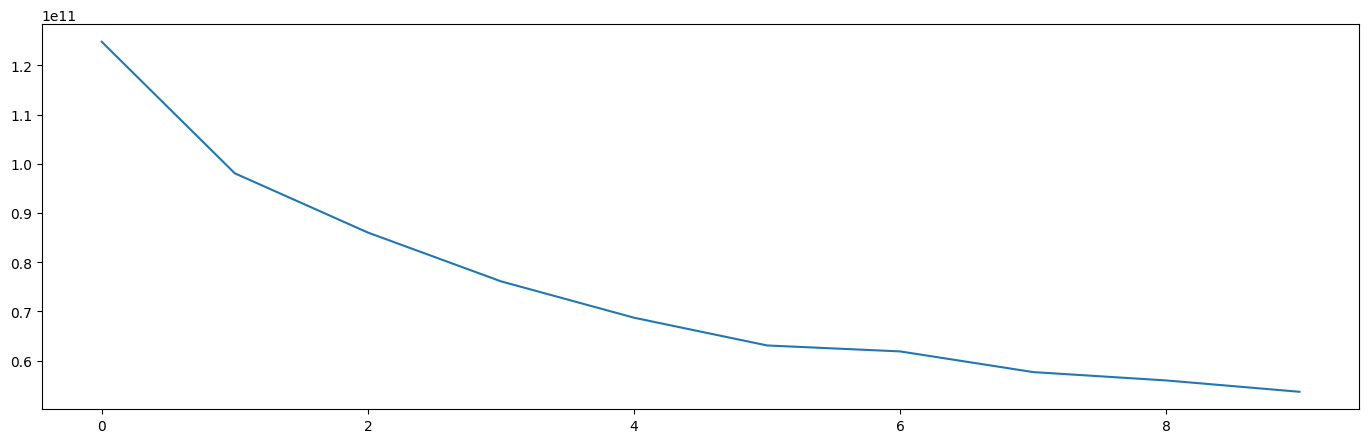

In [49]:
plt.plot(losses)